# Data Ingestion

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from urllib.parse import urlparse

In [2]:
def load_raw_data():
    TRAIN_FILE_LOCATION = '/kaggle/input/malicious-and-benign-urls/urldata.csv'
    df = pd.read_csv(TRAIN_FILE_LOCATION)
    df.drop(columns=['Unnamed: 0'], inplace=True)
    
    return df

raw_data = load_raw_data()

In [3]:
raw_data.head()

,url,label,result
0,https://www.google.com,benign,0
1,https://www.youtube.com,benign,0
2,https://www.facebook.com,benign,0
3,https://www.baidu.com,benign,0
4,https://www.wikipedia.org,benign,0


# Exploratory Data Analysis

In [4]:
print(f"Number of rows: {raw_data.shape[0]}")
print(f"Number of columns: {raw_data.shape[1]}")

Number of rows: 450176
Number of columns: 3


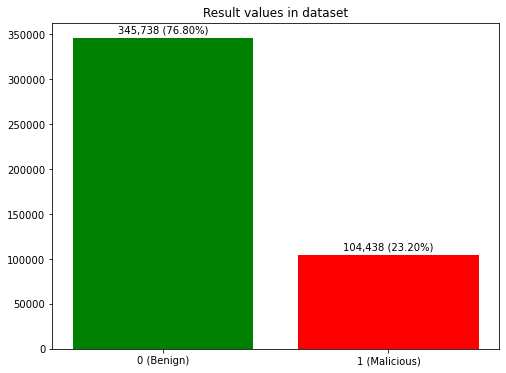

In [5]:
result_count = raw_data['result'].value_counts()
result_count_perc = result_count/sum(result_count.values)


fig, ax = plt.subplots(figsize=(8,6))
r1 = ax.bar('0 (Benign)', result_count[0], color='g')
ax.bar_label(r1, [f"{result_count[0]:,d} ({result_count_perc[0] * 100:.2f}%)"], padding=3)

r2 = ax.bar('1 (Malicious)', result_count[1], color='r')
ax.bar_label(r2, [f"{result_count[1]:,d} ({result_count_perc[1] * 100:.2f}%)"], padding=3)

ax.set_title("Result values in dataset")

plt.show()

The dataset is imbalanced with the number of `benign` (`result`=$0$) records being $4$ times greater than the number of `malicious` (`result`=$1$) records.

In [6]:
# Remove label column (redundant) and use the result column as our classes
df = raw_data.drop(columns=['label'])
df.head()

,url,result
0,https://www.google.com,0
1,https://www.youtube.com,0
2,https://www.facebook.com,0
3,https://www.baidu.com,0
4,https://www.wikipedia.org,0


# Split the dataset into train and test sets

In [7]:
def split_dataset(df, test_size=0.2):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    train_df.reset_index(drop=True, inplace=True)
    test_df.reset_index(drop=True, inplace=True)
    
    return (train_df, test_df)

train_df, test_df = split_dataset(df)
print(f"Train dataset size: {len(train_df):,d}")
print(f"Test dataset size: {len(test_df):,d}")

Train dataset size: 360,140
Test dataset size: 90,036


# Data Pre-processing

We need to extract some properties from the URL itself to use as features for training our models. We could start with partitioning the URL into its parts.

In [8]:
urlparse(train_df.loc[0]['url'])

ParseResult(scheme='https', netloc='www.carscover.com', path='/', params='', query='', fragment='')

In [9]:
def populate_url_fragments(df):
    def parse_url(url):
        result = urlparse(url)
        return (result.scheme, result.netloc, result.path, result.params, result.query, result.fragment)

    df[['scheme', 'hostname', 'path', 'params', 'query', 'fragment']] = pd.DataFrame(df['url'].apply(parse_url).apply(pd.Series))
    return df

train_df = populate_url_fragments(train_df)

In [10]:
train_df.head(15)

,url,result,scheme,hostname,path,params,query,fragment
0,https://www.carscover.com/,0,https,www.carscover.com,/,,,
1,http://defenceiq.us/,1,http,defenceiq.us,/,,,
2,https://www.drbita.blogspot.com/,0,https,www.drbita.blogspot.com,/,,,
3,https://www.bollymediainteractive.com/,0,https,www.bollymediainteractive.com,/,,,
4,https://www.usawaterski.org/Nationals/11M999CS...,0,https,www.usawaterski.org,/Nationals/11M999CS.HTM,,,
5,https://www.findradio.us/displayradio-37499.htm,0,https,www.findradio.us,/displayradio-37499.htm,,,
6,https://www.meb.gov.tr,0,https,www.meb.gov.tr,,,,
7,https://www.sweetcamgirl.com/blogs/?p=42,0,https,www.sweetcamgirl.com,/blogs/,,p=42,
8,https://www.librarything.com/authorcloud.php?v...,0,https,www.librarything.com,/authorcloud.php,,view=CovenantNetwork,
9,https://www.avril-source.com/gallery/thumbnail...,0,https,www.avril-source.com,/gallery/thumbnails.php,,album=1580,


## Explore URL scheme

In [11]:
train_df['scheme'].value_counts()

https     281936
http       78169
httpss        29
ftp            6
Name: scheme, dtype: int64

From the unique counts above, there is no such URL scheme as **httpss**. This is probably a typographical error of the scheme **https** so we need to correct that.

In [12]:
train_df.loc[(train_df['scheme'] == 'httpss'), 'scheme'] = 'https'

In [13]:
train_df['scheme'].value_counts()

https    281965
http      78169
ftp           6
Name: scheme, dtype: int64

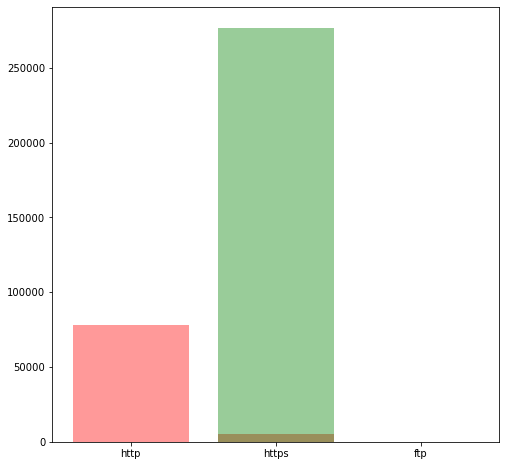

In [14]:
plt.figure(figsize=(8,8))
malicious_train_df = train_df[train_df['result'] == 1]
malicious_scheme_count = malicious_train_df['scheme'].value_counts()
plt.bar(malicious_scheme_count.keys(), malicious_scheme_count.values, color='red', alpha=0.4)
# x.keys()

benign_train_df = train_df[train_df['result'] == 0]
benign_scheme_count = benign_train_df['scheme'].value_counts()
plt.bar(benign_scheme_count.keys(), benign_scheme_count.values, color='green', alpha=0.4)

plt.show()